# Tree-Based Methods on 

## (a) Download the APS Failure data 
from: https://archive.ics.uci.edu/ml/datasets/APS+Failure+at+Scania+Trucks . The dataset contains a training set and a test set. The training set contains 60,000 rows, of which 1,000 belong to the positive class and 171 columns, of which one is the class column. All attributes are numeric.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import Imputer

In [2]:
train_df = pd.read_csv('data2/aps_failure_training_set.csv', header=14)
print('Training set shape:', train_df.shape)
test_df = pd.read_csv('data2/aps_failure_test_set.csv', header=14)
print('Test set shape:', test_df.shape)

Training set shape: (60000, 171)
Test set shape: (16000, 171)


## (b) Data Preparation
### i. Replace missing values with mean of the feature.

In [3]:
aps_df = train_df.append(test_df)
aps_df = aps_df.replace('na', np.NaN)
imp = Imputer(strategy='mean', axis=0)
X_imputed = imp.fit_transform(aps_df.iloc[:,1:])

### ii. calculate the coefficient of variation for each feature

In [4]:
X_imputed = pd.DataFrame(X_imputed, columns=aps_df.columns[1:])
summary_stats = X_imputed.describe()
coef_variation = summary_stats.loc['std'] / summary_stats.loc['mean']
print("The Coefficients if Variation of features are:")
print(coef_variation)

The Coefficients if Variation of features are:
aa_000      4.328608
ab_000      2.178273
ac_000      2.167653
ad_000    206.721500
ae_000     22.293670
af_000     18.209016
ag_000     91.460654
ag_001     42.084343
ag_002     17.625909
ag_003      8.753300
ag_004      5.475116
ag_005      2.964230
ag_006      2.352588
ag_007      2.812498
ag_008      6.274980
ag_009     32.167057
ah_000      2.315540
ai_000     18.506308
aj_000     43.144480
ak_000     78.622988
al_000      9.111991
am_0        9.067195
an_000      2.254227
ao_000      2.276114
ap_000      3.085885
aq_000      2.853471
ar_000     10.569202
as_000    113.882755
at_000     23.187060
au_000     86.085638
             ...    
dl_000     37.456647
dm_000     34.551802
dn_000      2.875142
do_000      2.174454
dp_000      2.009346
dq_000     21.184599
dr_000      6.585971
ds_000      2.289989
dt_000      2.165110
du_000      2.796194
dv_000      3.452224
dx_000      5.105320
dy_000      7.516916
dz_000     49.248806
ea_000  

### iii. Plot a correlation matrix

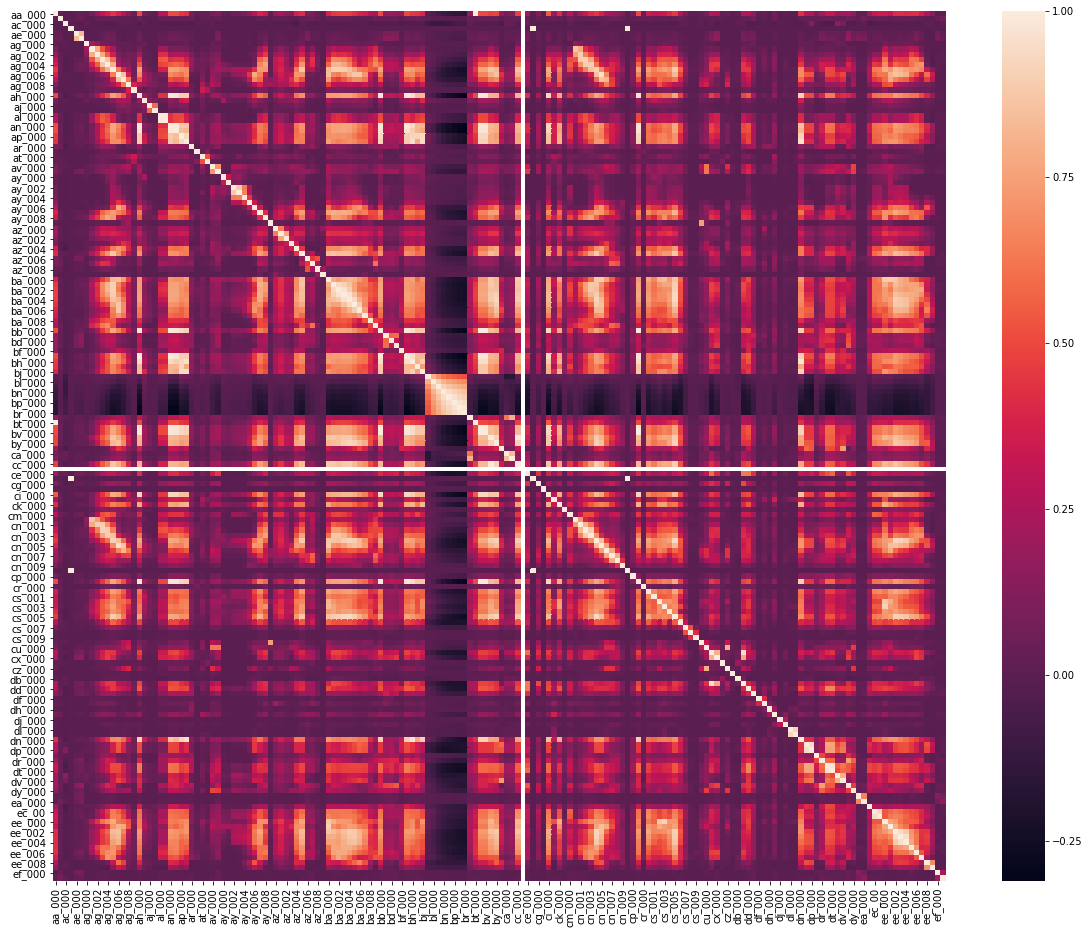

In [5]:
corr_matrix = X_imputed.corr()
plt.figure(figsize=(20, 16))
sns.heatmap(corr_matrix)

### iv. scatter plots and box plots for 13 features with the highest CV

In [6]:
highest_CVs = coef_variation.sort_values(ascending=False).head(13)
print("The 13 features with highest CV:\n")
print(highest_CVs)

The 13 features with highest CV:

cf_000    207.270274
co_000    206.876129
ad_000    206.721500
cs_009    192.522611
dj_000    122.128153
as_000    113.882755
dh_000    112.652450
df_000    111.369666
ag_000     91.460654
au_000     86.085638
ak_000     78.622988
az_009     77.999556
ay_009     77.461101
dtype: float64


In [7]:
features_highestCV = highest_CVs.index.values

In [8]:
new_df = pd.DataFrame(X_imputed)
new_df['class'] = aps_df['class'].values

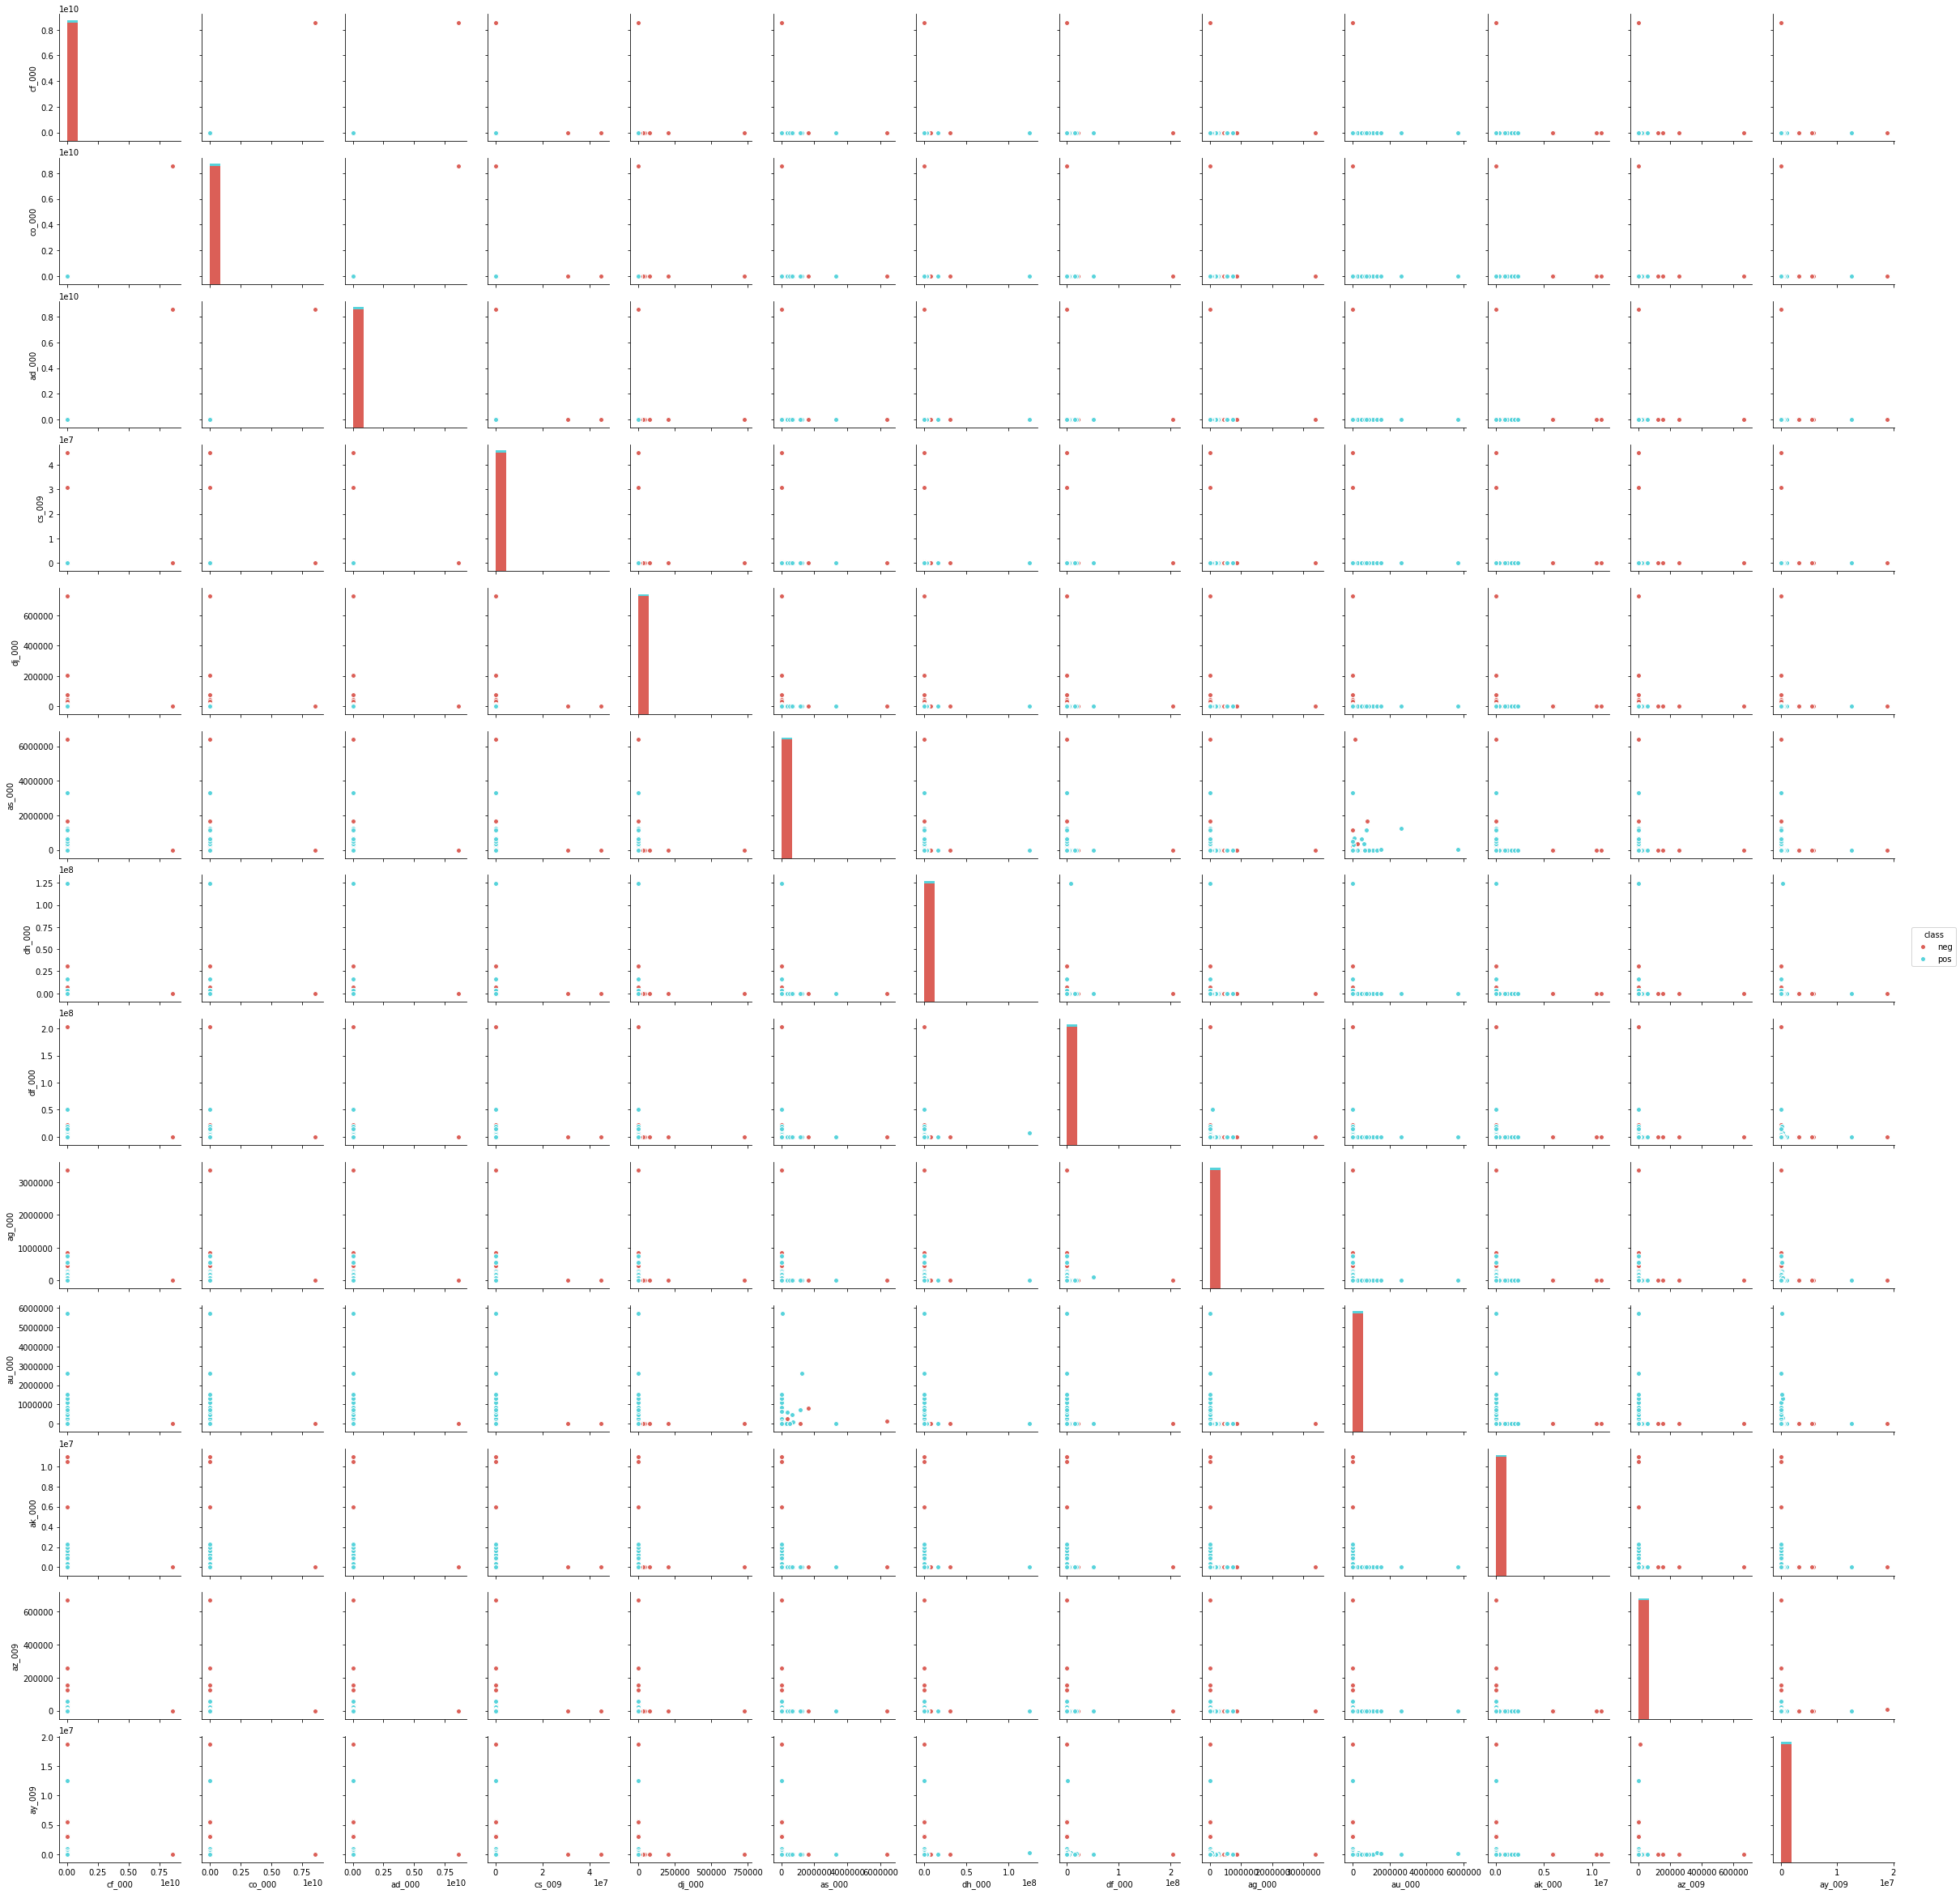

In [9]:
sns.pairplot(new_df, vars=features_highestCV, hue='class', palette='hls')

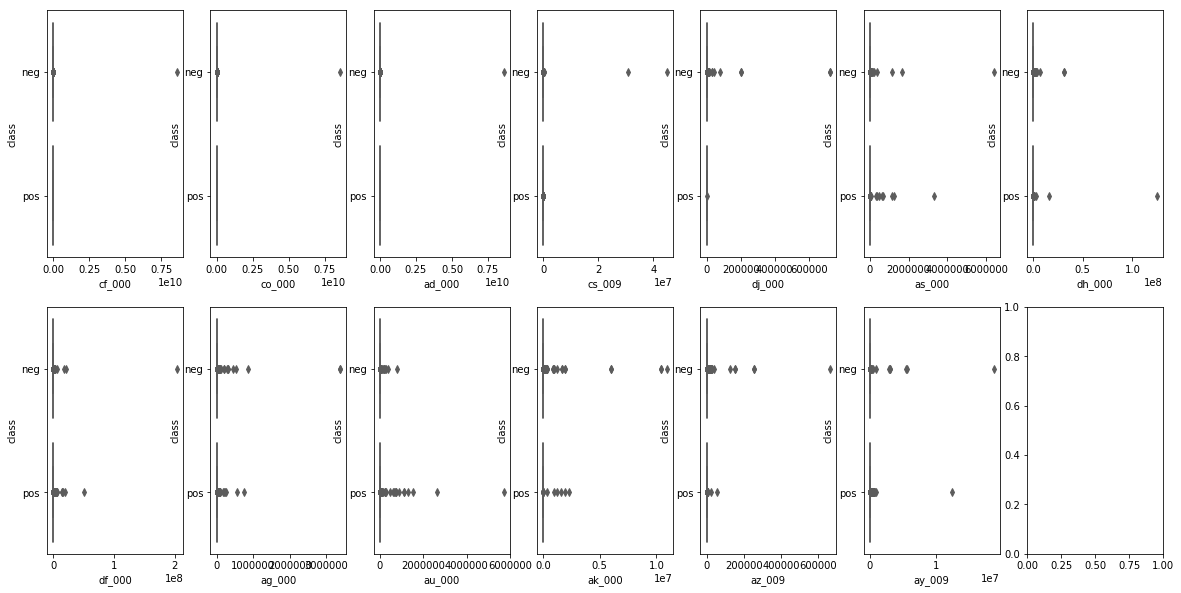

In [10]:
fig, axs = plt.subplots(2, 7, figsize=(20,10))
for i, ft in enumerate(features_highestCV):
    sns.boxplot(x=ft, y='class', data=new_df, palette='hls', ax=axs[i//7, i%7])

### v.

In [11]:
pos_df = new_df.loc[new_df['class'] == 'pos']
neg_df = new_df.loc[new_df['class'] == 'neg']
print('The number of positive data is', len(pos_df))
print('The number of negtive data is', len(neg_df))

The number of positive data is 1375
The number of negtive data is 74625


In [12]:
print('The ratio of positive versus negtive is', len(neg_df)/len(pos_df))

The ratio of positive versus negtive is 54.27272727272727


#### This data set is imbalanced.

## (c) Train a random forest

In [14]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

In [15]:
new_df['class'] = new_df['class'].replace('neg', 0).replace('pos', 1)
X_train = new_df.iloc[:60000,:-1]
X_test = new_df.iloc[60000:,:-1]
y_train = new_df.iloc[:60000,-1]
y_test = new_df.iloc[60000:,-1]

In [16]:
#train a random forest
rf = RandomForestClassifier(n_estimators=100, oob_score=True)
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=True, random_state=None, verbose=0, warm_start=False)

### confusion matrix, ROC, AUC, and misclassification for training set

In [17]:
train_pred = rf.predict(X_train)
print('Confusion matrix:\n')
print(confusion_matrix(y_train, train_pred))

Confusion matrix:

[[59000     0]
 [    0  1000]]


In [18]:
def plotROC(y_true, y_pred):
    '''
    plot the ROC curve
    '''
    fpr, tpr, threshold = metrics.roc_curve(y_true, y_pred)
    roc_auc = metrics.auc(fpr, tpr)

    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1.05])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

DEBUG:matplotlib.font_manager:findfont: Matching :family=sans-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=12.0 to DejaVu Sans ('/Users/lizi/venv/lib/python3.6/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf') with score of 0.050000


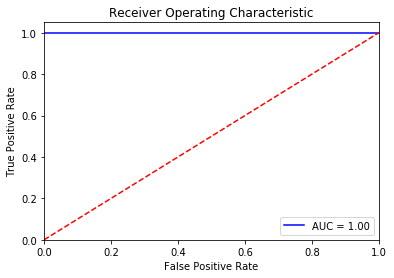

In [19]:
plotROC(y_train, train_pred)

In [20]:
print('The misclassification rate for training set is', 1 - accuracy_score(y_train, train_pred))

The misclassification rate for training set is 0.0


### confusion matrix, ROC, AUC, and misclassification for test set

In [21]:
test_pred = rf.predict(X_test)
print('Confusion matrix:\n')
print(confusion_matrix(y_test, test_pred))

Confusion matrix:

[[15608    17]
 [  102   273]]


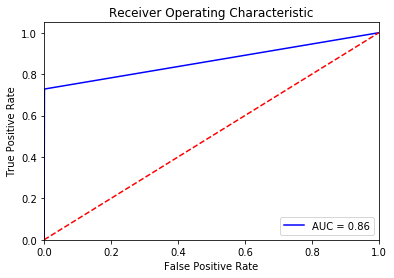

In [22]:
plotROC(y_test, test_pred)

In [23]:
print('The Out of Bag error estimate is', 1 - rf.oob_score_)
print('The test error is', 1 - accuracy_score(y_test, test_pred))

The Out of Bag error estimate is 0.005950000000000011
The test error is 0.007437499999999986


## (d) Handle Imbalanced Classes In Random Forest

In random forest, the method add a weight to the class. The weight can be calculated from the number of specific class.

In [24]:
#classes are automatically weighted inversely proportional 
#to how frequently they appear in the data
rf_balanced = RandomForestClassifier(n_estimators=100, oob_score=True, 
                                     class_weight='balanced_subsample')
rf_balanced.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight='balanced_subsample',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=1, oob_score=True, random_state=None,
            verbose=0, warm_start=False)

### confusion matrix, ROC, AUC, and misclassification for training set

In [25]:
train_pred = rf_balanced.predict(X_train)
print('Confusion matrix:\n')
print(confusion_matrix(y_train, train_pred))

Confusion matrix:

[[59000     0]
 [    0  1000]]


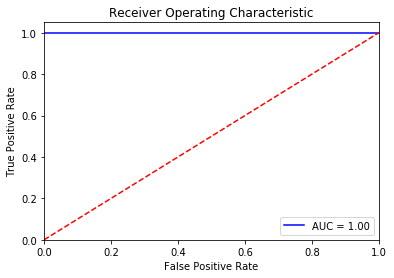

The misclassification rate for training set is 0.0


In [26]:
plotROC(y_train, train_pred)
print('The misclassification rate for training set is', 1 - accuracy_score(y_train, train_pred))

### confusion matrix, ROC, AUC, and misclassification for test set

In [27]:
test_pred = rf_balanced.predict(X_test)
print('Confusion matrix:\n')
print(confusion_matrix(y_test, test_pred))

Confusion matrix:

[[15612    13]
 [  167   208]]


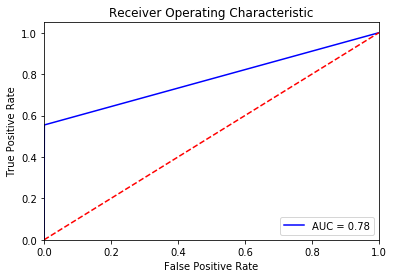

The Out of Bag error estimate is 0.005950000000000011
The test error is 0.011249999999999982


In [28]:
plotROC(y_test, test_pred)
print('The Out of Bag error estimate is', 1 - rf.oob_score_)
print('The test error is', 1 - accuracy_score(y_test, test_pred))

The train errors in (d) and (c) are the same. The test error in (d) is worse than that in (c).

### (e) Model Tree

Use scikit learn to call Weka to train Logistic Model Trees for classification.

In [13]:
import weka.core.jvm as jvm
jvm.start(packages=True)
import weka.core.converters as converters
from weka.classifiers import Evaluation, PredictionOutput
from weka.core.classes import Random
from weka.classifiers import Classifier
from weka.plot.classifiers import plot_roc
from weka.core.converters import Loader

DEBUG:weka.core.jvm:Adding bundled jars
DEBUG:weka.core.jvm:Classpath=['/Users/lizi/venv/lib/python3.6/site-packages/javabridge/jars/rhino-1.7R4.jar', '/Users/lizi/venv/lib/python3.6/site-packages/javabridge/jars/runnablequeue.jar', '/Users/lizi/venv/lib/python3.6/site-packages/javabridge/jars/cpython.jar', '/Users/lizi/venv/lib/python3.6/site-packages/weka/lib/python-weka-wrapper.jar', '/Users/lizi/venv/lib/python3.6/site-packages/weka/lib/weka.jar']
DEBUG:weka.core.jvm:MaxHeapSize=default
DEBUG:weka.core.jvm:Package support enabled
DEBUG:javabridge.jutil:Creating JVM object
DEBUG:javabridge.jutil:Launching VM in non-python thread
DEBUG:javabridge.jutil:Attaching to VM in monitor thread
DEBUG:javabridge.jutil:Signalling caller


In [14]:
new_df['class'] = new_df['class'].replace(1, 'pos').replace(0, 'neg')
newTrainPath = 'data2/new_aps_train.csv'
new_df.head(60000).to_csv(newTrainPath, index=False)
loader = Loader(classname="weka.core.converters.CSVLoader")
train_data = loader.load_file(newTrainPath)
train_data.class_is_last()

In [67]:
clf = Classifier(classname="weka.classifiers.trees.LMT")
evaluation = Evaluation(train_data)
evaluation.crossvalidate_model(clf, train_data, 5, Random(1))

In [70]:
print(evaluation.matrix())

=== Confusion Matrix ===

     a     b   <-- classified as
 58854   146 |     a = neg
   350   650 |     b = pos



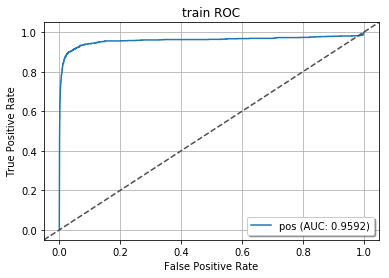

In [73]:
plot_roc(evaluation, title='train ROC',class_index=[1], wait=False)

In [33]:
clf = Classifier(classname="weka.classifiers.trees.LMT")
clf.build_classifier(train_data)

In [68]:
#prepare test data
newTestPath = 'data2/new_aps_test.csv'
new_df.iloc[60000:].to_csv(newTestPath, index=False)

test_data = loader.load_file(newTestPath)
test_data.class_is_last()

array([0., 0., 0., ..., 0., 0., 0.])

=== Confusion Matrix ===

     a     b   <-- classified as
 15577    48 |     a = neg
   106   269 |     b = pos
 

The AUC for test set is 0.9724980906666667


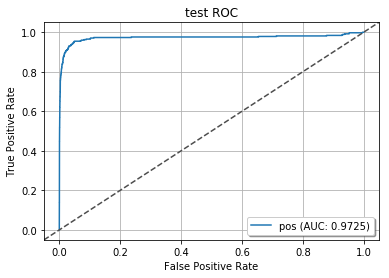

In [72]:
# pred_output = PredictionOutput(
#         classname="weka.classifiers.evaluation.output.prediction.PlainText", options=["-distribution"])
eval_test = Evaluation(train_data)
eval_test.test_model(clf, test_data)

print(eval_test.matrix(), '\n')
print("The AUC for test set is", eval_test.area_under_roc(1))
plot_roc(eval_test, title='test ROC',class_index=[1], wait=False)

In [79]:
print('The error estimated by CV is', (350+146)/600000)
print('The test error is', eval_test.incorrect/160000)

The error estimated by CV is 0.0008266666666666666
The test error is 0.0009625


The test error is a little larger than estimated error by CV.